In [51]:
import sys, os, re, pickle
import pandas as pd
from collections import defaultdict
from openbabel import openbabel as ob

os.chdir(os.environ['LIGAN_ROOT'])
import liGAN

os.getcwd()

'/net/pulsar/home/koes/mtr22/gan'

In [25]:
data_file = 'data/it2_tt_0_lowrmsd.types'
data_root = '/net/pulsar/home/koes/paf46/Research/CrossDocking_script/PocketomeOutput/PocketomeGenCross_Output'
src_pat = re.compile(r'(.+)_(\d+)')

with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [53]:
def getNumHydrogens(ob_atom):
    return ob_atom.GetTotalDegree() - ob_atom.GetHvyDegree()

funcs = [
    ob.OBAtom.GetAtomicNum, 
    ob.OBAtom.IsAromatic,
    ob.OBAtom.IsHbondAcceptor,
    ob.OBAtom.IsHbondDonor,
    ob.OBAtom.GetFormalCharge,
    getNumHydrogens,
]

def defaultdict_int(): # allow pickling
    return defaultdict(int)

rec_counts = defaultdict(defaultdict_int)
lig_counts = defaultdict(defaultdict_int)

line_idx = 0
with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [43]:
while line_idx < n_lines:
    line = lines[line_idx]
    rec_src, lig_src = line.rstrip().split(' ')[3:5]
    rec_src_no_ext = os.path.splitext(rec_src)[0]
    lig_src_no_ext = os.path.splitext(lig_src)[0]

    m = src_pat.match(rec_src_no_ext)
    rec_mol_base = m.group(1) + '.pdb'
    rec_idx = int(m.group(2))
    rec_mol_file = os.path.join(data_root, rec_mol_base)
    rec_mol = liGAN.molecules.read_ob_mols_from_file(rec_mol_file, '.pdb')[rec_idx]

    m = src_pat.match(lig_src_no_ext)
    lig_mol_base = m.group(1) + '.sdf'
    lig_idx = int(m.group(2))
    lig_mol_file = os.path.join(data_root, lig_mol_base)
    lig_mol = liGAN.molecules.read_ob_mols_from_file(lig_mol_file, '.sdf')[lig_idx]

    for atom in ob.OBMolAtomIter(rec_mol):
        for func in funcs:
            rec_counts[func.__name__][func(atom)] += 1

    for atom in ob.OBMolAtomIter(lig_mol):
        for func in funcs:
            lig_counts[func.__name__][func(atom)] += 1

    line_idx += 1
    if line_idx % 100 == 0: 
        pct_done = line_idx/n_lines * 100
        print('[{:.2f}%]'.format(pct_done), end=' ')
        
        with open('rec_counts.pkl', 'wb') as f:
            pickle.dump(rec_counts, f)
        with open('lig_counts.pkl', 'wb') as f:
            pickle.dump(lig_counts, f)

In [47]:
line_idx, n_lines, pct_done

(725033, 725033, 100.0)

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


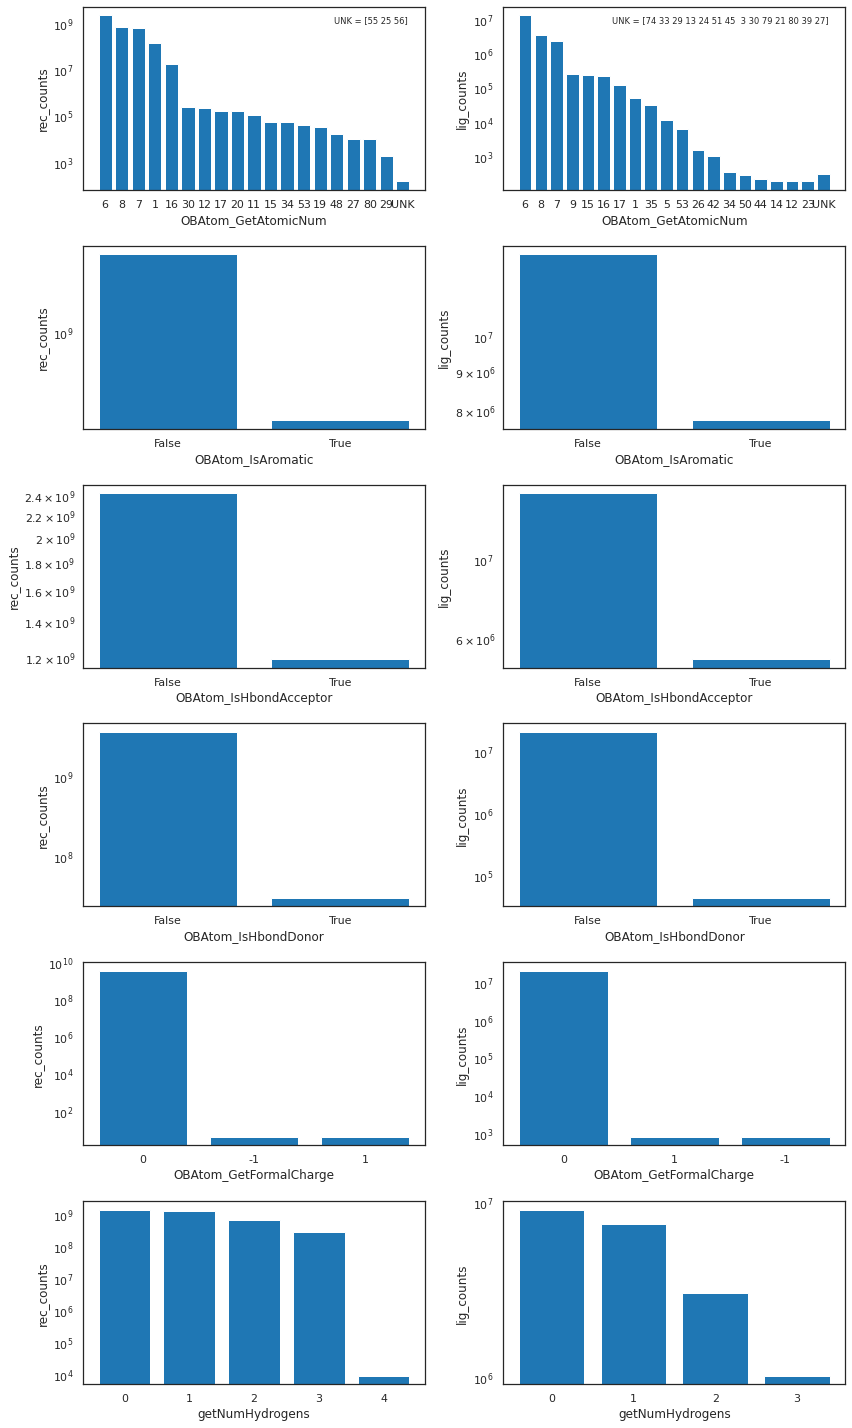

In [54]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

with open('rec_counts.pkl', 'rb') as f:
    rec_counts = pickle.load(f)
with open('lig_counts.pkl', 'rb') as f:
    lig_counts = pickle.load(f)

def plot_counts(counts, ax, thresh=0.0, symbols=False):
    
    # get labels and counts as arrays
    labels = np.array(list(counts.keys()))
    counts = np.array(list(counts.values()))
        
    # sort arrays by label
    idx = np.argsort(-counts)
    labels = labels[idx]
    counts = counts[idx]
    
    if symbols:
        labels = np.array([ob.GetSymbol(int(l)) for l in labels])
    
    # apply threshold
    idx = (counts > thresh)
    n_unk = counts[~idx].sum()
    unk_labels = labels[~idx]

    if n_unk > 0 and len(labels) > 5:
        labels = labels[idx]
        counts = counts[idx]
        labels = np.append(labels, 'UNK')
        counts = np.append(counts, n_unk)
        
    # convert counts to percents
    #counts = counts / counts.sum()
    
    x = np.arange(len(counts))
    ax.bar(x, counts)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if 'UNK' in labels:
        ax.text(0.95, 0.95, 'UNK = {}'.format(unk_labels),
            fontsize='x-small',
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes
        )
    if len(labels) > 20:
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize('x-small')

fig, axes = plt.subplots(len(funcs), 2, figsize=(12, 20))

thresh = 100

for i, func in enumerate(funcs):
    ax = axes[i][0]
    plot_counts(rec_counts[func.__name__], ax, thresh, symbols=(False and i==0))
    ax.set_xlabel(func.__name__)
    ax.set_ylabel('rec_counts')
    ax.set_yscale('log')

for i, func in enumerate(funcs):
    ax = axes[i][1]
    plot_counts(lig_counts[func.__name__], ax, thresh, symbols=(False and i==0))
    ax.set_xlabel(func.__name__)
    ax.set_ylabel('lig_counts')
    ax.set_yscale('log')

fig.tight_layout()

In [138]:
for atomic_num in sorted(rec_counts[funcs[0].__name__].keys()):
    symbol = ob.GetSymbol(atomic_num)
    cov_radius = ob.GetCovalentRad(atomic_num)
    vdw_radius = ob.GetVdwRad(atomic_num)
    print('{}\t{}\t{}\t{}'.format(atomic_num, symbol, cov_radius, vdw_radius))

1	H	0.31	1.1
6	C	0.76	1.7
7	N	0.71	1.55
8	O	0.66	1.52
11	Na	1.66	2.27
12	Mg	1.41	1.73
15	P	1.07	1.8
16	S	1.05	1.8
17	Cl	1.02	1.75
19	K	2.03	2.75
20	Ca	1.76	2.31
25	Mn	1.39	2.05
27	Co	1.26	2.0
29	Cu	1.32	2.0
30	Zn	1.22	2.1
34	Se	1.2	1.9
48	Cd	1.44	2.2
53	I	1.39	1.98
55	Cs	2.44	3.43
56	Ba	2.15	2.68
80	Hg	1.32	2.05


# Bond adding experiment

In [187]:
sys.path.append('/net/pulsar/home/koes/mtr22')
import param_search

add_expt_dir = os.path.join(os.environ['LIGAN_ROOT'], 'new_atom_typing')
os.chdir(add_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing'

In [83]:
add_params = param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_train0.types',
    n_examples= 100000,
    typer_fns = ['oad', 'oadc', 'on', 'oh'],
    use_ob_mol = [0, 1]
)
len(add_params)

8

In [176]:
name_format = 'add_{typer_fns}_{use_ob_mol}'
template_file = 'add.sh'

add_job_files = param_search.setup(
    expt_dir=add_expt_dir,
    name_format=name_format,
    template_file=template_file,
    param_space=add_params,
)
add_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oad_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oad_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oadc_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oadc_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_on_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_on_1/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oh_0/add.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/add_oh_1/add.sh']

In [134]:
job_ids = param_search.submit(add_job_files)
print(job_ids)

[6814416, 6814417, 6814418, 6814419, 6814420, 6814421, 6814422, 6814423]


In [177]:
import pandas as pd
add_df = pd.DataFrame(dict(
    job_id=[
        [6813229, 6813230, 6813231, 6813232, 6813233, 6813234, 6813235, 6813236],
        [6813240, 6813241, 6813242, 6813243, 6813244, 6813245, 6813246, 6813247],
        [6813291, 6813292, 6813293, 6813294, 6813295, 6813296, 6813297, 6813298],
        [6814300, 6814301, 6814302, 6814303, 6814304, 6814305, 6814306, 6814307],
        [6814308, 6814309, 6814310, 6814311, 6814312, 6814313, 6814314, 6814315],
        [6814316, 6814317, 6814318, 6814319, 6814320, 6814321, 6814322, 6814323],
        [6814326, 6814327, 6814328, 6814329, 6814330, 6814331, 6814332, 6814333],
        [6814344, 6814345, 6814346, 6814347, 6814348, 6814349, 6814350, 6814351],
        [6814416, 6814417, 6814418, 6814419, 6814420, 6814421, 6814422, 6814423],
    ]
)).explode('job_id')
#df.index.rename('submit_id', inplace=True)
#df.groupby('submit_id').count()

In [178]:
import numpy as np
import glob, re
import param_search

qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

add_df = add_df.merge(qstat, on='job_id', how='left')

def find_work_dir(x):
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    f = glob.glob('*/{}.*'.format(x['job_id']))
    if f:
        return os.path.dirname(f[0])
    # else cancelled before running

def find_job_state(x):
    if 'job_state' in x and not pd.isnull(x['job_state']):
        return x['job_state']
    if x['work_dir'] is None:
        return 'CAN'
    if x['stderr'] is not None:
        return 'ERR'
    return 'OK'

def catch_exc(func, exc_type=Exception, default=None):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except exc_type as e:
            return default
    return wrapper

add_df['work_dir'] = add_df.apply(find_work_dir, axis=1)
add_df['job_name'] = add_df['work_dir'].map(catch_exc(os.path.basename, TypeError))
add_df['job_file'] = add_df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
add_df['stdout_file'] = add_df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
add_df['stderr_file'] = add_df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
add_df['stdout'] = add_df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
add_df['stderr'] = add_df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
add_df['job_state'] = add_df.apply(find_job_state, axis=1)

In [179]:
add_df.set_index(['job_id', 'job_name'])[['runtime', 'node_id', 'job_state', 'stderr']]

,,runtime,node_id,job_state,stderr
job_id,job_name,,,,
6813229,add_oad_0,NaN,NaN,ERR,RuntimeError: Pre-condition Violation
6813230,add_oad_1,NaN,NaN,ERR,RuntimeError: Pre-condition Violation
6813231,add_oadc_0,NaN,NaN,ERR,RuntimeError: Pre-condition Violation
6813232,add_oadc_1,NaN,NaN,ERR,RuntimeError: Pre-condition Violation
6813233,add_on_0,NaN,NaN,ERR,RuntimeError: Pre-condition Violation
...,...,...,...,...,...
6814419,add_oadc_1,NaN,NaN,OK,None
6814420,add_on_0,NaN,NaN,OK,None
6814421,add_on_1,NaN,NaN,OK,None


In [406]:
add_metrics = param_search.metrics(add_job_files, metric_pat='(.*)metrics')
add_metrics

,example_idx,lig_name,pose_idx,n_atoms_diff,elem_count_diff,prop_count_diff,rd_sim,ob_sim,smi_match,add_time,data_root,data_file,n_examples,typer_fns,use_ob_mol,job_name
0,0,4gnt_A_rec_5f74_amp_lig_tt_min,0,0,0,0,1.0,1.0,True,0.0805,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oad,0,add_oad_0
1,1,5n10_B_rec_5f74_amp_lig_tt_min,0,0,0,0,1.0,1.0,True,0.0704,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oad,0,add_oad_0
2,2,5f74_A_rec_5f74_amp_lig_tt_min,0,0,0,0,1.0,1.0,True,0.0707,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oad,0,add_oad_0
3,3,5n10_A_rec_5f74_amp_lig_tt_min,0,0,0,0,1.0,1.0,True,0.0699,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oad,0,add_oad_0
4,4,5f74_A_rec_5f74_amp_lig_tt_docked,3,0,0,0,1.0,1.0,True,0.0694,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oad,0,add_oad_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32565,32565,3eqa_A_rec_1gah_acr_lig_tt_docked,1,0,0,0,1.0,1.0,True,29.5617,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oh,1,add_oh_1
32566,32566,3eqa_A_rec_1gah_acr_lig_tt_docked,4,0,0,0,1.0,1.0,True,26.7070,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oh,1,add_oh_1
32567,32567,3eqa_A_rec_1gah_acr_lig_tt_docked,6,0,0,0,1.0,1.0,True,32.5920,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oh,1,add_oh_1
32568,32568,1gai_A_rec_1gai_gac_lig_tt_docked,0,0,0,0,1.0,1.0,True,32.2094,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,100000,oh,1,add_oh_1


In [407]:
add_metrics.groupby(['typer_fns', 'use_ob_mol'])[['example_idx']].count()

example_idx
typer_fns use_ob_mol             
oad       0                100000
          1                100000
oadc      0                100000
          1                100000
oh        0                 32570
          1                 32570
on        0                100000
          1                100000

oad  = H acceptor/donor
oadc = H acceptor/donor + formal charge
on   = number of bonded Hs
oh   = explicit H atoms


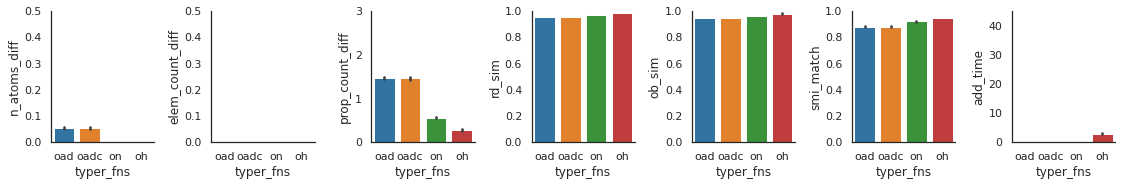

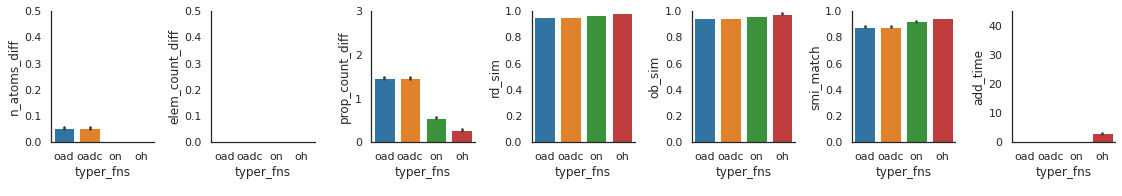

In [408]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

typer_fn_map = dict(
    oad ='H acceptor/donor',
    oadc='H acceptor/donor + formal charge',
    on  ='number of bonded Hs',
    oh  ='explicit H atoms',
)

plot_df = add_metrics.reset_index()

for use_ob_mol in [0, 1]:
    fig = param_search.plot(
        plot_df[plot_df['use_ob_mol'] == use_ob_mol],
        x='typer_fns',
        y=[
            'n_atoms_diff',
            'elem_count_diff',
            'prop_count_diff',
            'rd_sim',
            'ob_sim',
            'smi_match',
            'add_time'
        ],
        hue=None,
        n_cols=7,
        width=2.25,
        height=3,
        plot_func=sns.barplot,
        ylim=dict(
            n_atoms_diff=[0, ],
            elem_count_diff=[0, ],
            prop_count_diff=[0, 3],
            rd_sim=[0, 1],
            ob_sim=[0, 1],
            smi_match=[0, 1],
            add_time=[0, 45],
        )
    )

print('\n'.join(
    '{} = {}'.format(tf.ljust(4), typer_fn_map[tf]) for tf in ['oad', 'oadc', 'on', 'oh']
))

In [416]:
add_metrics.groupby(['typer_fns'])[['n_atoms_diff','elem_count_diff','prop_count_diff','rd_sim','ob_sim','smi_match','add_time']].mean()

,n_atoms_diff,elem_count_diff,prop_count_diff,rd_sim,ob_sim,add_time
typer_fns,,,,,,
oad,0.05171,0.0,1.450720,0.952214,0.943298,0.067766
oadc,0.05171,0.0,1.450720,0.952214,0.943298,0.067436
oh,0.00000,0.0,0.274854,0.980272,0.977745,2.839574
on,0.00000,0.0,0.551280,0.966747,0.959204,0.068697


# Atom fitting experiment

In [397]:
sys.path.append('/net/pulsar/home/koes/mtr22')
import param_search

fit_expt_dir = os.path.join(add_expt_dir, 'atom_fitting')
os.chdir(fit_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting'

In [398]:
fit_params = param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols.types',
    n_examples= 10000,
    typer_fns = ['oad', 'oadc', 'on', 'oh'],
    radius_fn = ['v', 'c'],
    apply_prop_conv = [0, 1],
)
len(fit_params)

16

In [399]:
name_format = 'fit_{typer_fns}-{radius_fn}_{apply_prop_conv}'

for template_file in ['generate.config', 'generate.sh']:
    fit_job_files = param_search.setup(
        expt_dir=fit_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=fit_params,
    )

fit_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-v_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-v_1/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-c_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-c_1/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oadc-v_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oadc-v_1/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oadc-c_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oadc-c_1/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_on-v_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_on-v_1/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_on-c_0/generate.sh',
 '/net/pulsar/home/k

In [216]:
job_ids = param_search.submit(fit_job_files)
print(job_ids)

[6814442, 6814443, 6814444, 6814445, 6814446, 6814447, 6814448, 6814449, 6814450, 6814451, 6814452, 6814453, 6814454, 6814455, 6814456, 6814457]


In [400]:
import pandas as pd
fit_df = pd.DataFrame(dict(
    job_id=[
        [6814426, 6814427, 6814428, 6814429, 6814430, 6814431, 6814432, 6814433, 6814434, 6814435, 6814436, 6814437, 6814438, 6814439, 6814440, 6814441],
        [6814442, 6814443, 6814444, 6814445, 6814446, 6814447, 6814448, 6814449, 6814450, 6814451, 6814452, 6814453, 6814454, 6814455, 6814456, 6814457],
        #
    ]
)).explode('job_id')
#df.index.rename('submit_id', inplace=True)
#df.groupby('submit_id').count()

In [401]:
import numpy as np
import glob, re
import param_search

qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

fit_df = fit_df.merge(qstat, on='job_id', how='left')
fit_df['work_dir'] = fit_df.apply(find_work_dir, axis=1)
fit_df['job_name'] = fit_df['work_dir'].map(catch_exc(os.path.basename, TypeError))
fit_df['job_file'] = fit_df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
fit_df['stdout_file'] = fit_df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
fit_df['stderr_file'] = fit_df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
fit_df['stdout'] = fit_df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
fit_df['stderr'] = fit_df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
fit_df['job_state'] = fit_df.apply(find_job_state, axis=1)

In [402]:
fit_df.set_index(['job_id', 'job_name'])[['runtime', 'node_id', 'job_state', 'stderr']]

,,runtime,node_id,job_state,stderr
job_id,job_name,,,,
6814426,fit_oad-v_0,NaN,NaN,OK,None
6814427,fit_oad-v_1,NaN,NaN,OK,None
6814428,fit_oad-c_0,NaN,NaN,OK,None
6814429,fit_oad-c_1,NaN,NaN,OK,None
6814430,fit_oadc-v_0,NaN,NaN,OK,None
6814431,fit_oadc-v_1,NaN,NaN,OK,None
6814432,fit_oadc-c_0,NaN,NaN,OK,None
6814433,fit_oadc-c_1,NaN,NaN,OK,None
6814434,fit_on-v_0,NaN,NaN,OK,None


In [403]:
fit_metrics = param_search.metrics(fit_job_files, metric_pat='(.*)metrics')
fit_metrics

/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-v_0/generate.sh No columns to parse from file
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (18,39,81) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (18,39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit_oad-c_1/generate.sh No columns to parse from file
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/n

,lig_name,sample_idx,lig_norm,lig_variance,lig_n_atoms,lig_radius,lig_n_frags,lig_valid,lig_reason,lig_MW,...,lig_fit_add_prop_diff,lig_fit_add_exact_props,lig_fit_add_RMSD,data_root,data_file,n_examples,typer_fns,radius_fn,apply_prop_conv,job_name
0,1eez_A_rec_2gj6_3ib_lig_tt_min_0.sdf,0,39.848171,784.681885,27.0,3.229908,1.0,True,valid molecule,187.242,...,12.0,False,0.361205,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,10000,oad,v,1,fit_oad-v_1
1,1eez_A_rec_2gj6_3ib_lig_tt_min_0.sdf,1,39.849209,757.385986,27.0,3.229906,1.0,True,valid molecule,187.242,...,0.0,True,0.361521,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,10000,oad,v,1,fit_oad-v_1
2,1eez_A_rec_2gj6_3ib_lig_tt_min_0.sdf,2,39.848763,867.675720,27.0,3.229906,1.0,True,valid molecule,187.242,...,12.0,False,0.361434,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,10000,oad,v,1,fit_oad-v_1
3,1eez_A_rec_2gj6_3ib_lig_tt_min_0.sdf,3,39.848068,793.279541,27.0,3.229906,1.0,True,valid molecule,187.242,...,0.0,True,0.361275,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,10000,oad,v,1,fit_oad-v_1
4,1eez_A_rec_2gj6_3ib_lig_tt_min_0.sdf,4,39.848392,918.530273,27.0,3.229900,1.0,True,valid molecule,187.242,...,12.0,False,0.361450,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,10000,oad,v,1,fit_oad-v_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12975,5kq5_B_rec_4qfr_32j_lig_tt_min_0.sdf,5,12.088162,119.813095,38.0,7.191728,1.0,True,valid molecule,394.839,...,22.0,False,NaN,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,10000,oh,c,1,fit_oh-c_1
12976,5kq5_B_rec_4qfr_32j_lig_tt_min_0.sdf,6,12.045920,121.175446,38.0,7.191729,1.0,True,valid molecule,394.839,...,21.0,False,NaN,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,10000,oh,c,1,fit_oh-c_1
12977,5kq5_B_rec_4qfr_32j_lig_tt_min_0.sdf,7,12.137760,127.152237,38.0,7.191726,1.0,True,valid molecule,394.839,...,22.0,False,NaN,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,10000,oh,c,1,fit_oh-c_1
12978,5kq5_B_rec_4qfr_32j_lig_tt_min_0.sdf,8,12.148796,129.372345,38.0,7.191729,1.0,True,valid molecule,394.839,...,25.0,False,NaN,/net/pulsar/home/koes/paf46_shared/PocketomeGe...,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_...,10000,oh,c,1,fit_oh-c_1


In [404]:
fit_metrics.groupby(['job_name'])[['sample_idx']].count()

,sample_idx
job_name,
fit_oad-c_0,39090
fit_oad-v_1,37320
fit_oadc-c_0,36930
fit_oadc-c_1,36470
fit_oadc-v_0,36300
fit_oadc-v_1,33510
fit_oh-c_0,12980
fit_oh-c_1,12980
fit_oh-v_0,12980


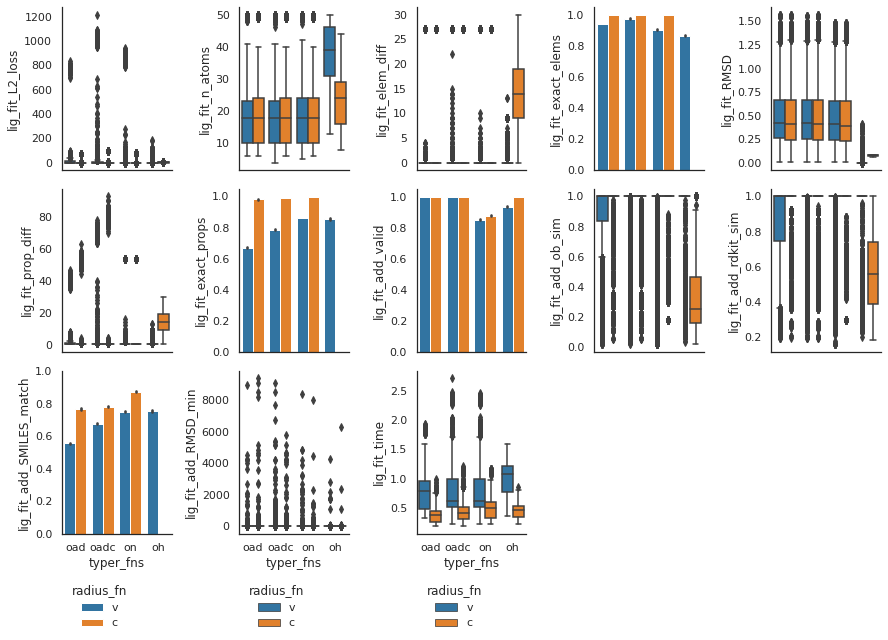

In [409]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

def my_plot(*args, **kwargs):
    y = kwargs['y']
    if 'valid' in y or 'SMILES_match' in y or 'exact' in y:
        return sns.barplot(*args, **kwargs)
    else:
        return sns.boxplot(*args, **kwargs)

plot_df = fit_metrics.reset_index()

fig = param_search.plot(
    plot_df, #[plot_df['radius_fn'] == 'c'],
    x='typer_fns',
    y=[
        'lig_fit_L2_loss',
        'lig_fit_n_atoms',
        'lig_fit_elem_diff',
        'lig_fit_exact_elems',
        'lig_fit_RMSD',
        
        'lig_fit_prop_diff',
        'lig_fit_exact_props',
        'lig_fit_add_valid',
        'lig_fit_add_ob_sim',
        'lig_fit_add_rdkit_sim',
        
        'lig_fit_add_SMILES_match',
        'lig_fit_add_RMSD_min',
        'lig_fit_time',
    ],
    hue='radius_fn',
    n_cols=5,
    width=2.5,
    height=3,
    plot_func=my_plot,
    ylim=dict(lig_fit_add_SMILES_match=[0,1])
)

In [417]:
plot_df['lig_fit_add_reason'].unique()

array(['valid molecule', 'failed to kekulize', 'multiple fragments'],
      dtype=object)

In [419]:
reasons = plot_df['lig_fit_add_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_fit_add_reason'] == r)

plot_df.groupby(['typer_fns', 'radius_fn'])[reasons].mean() * 100

valid molecule  failed to kekulize  multiple fragments
typer_fns radius_fn                                                        
oad       c               99.994884            0.005116            0.000000
          v              100.000000            0.000000            0.000000
oadc      c               99.995913            0.004087            0.000000
          v               99.994270            0.002865            0.002865
oh        c               99.992296            0.007704            0.000000
          v               93.567026            6.340524            0.092450
on        c               87.673788           12.326212            0.000000
          v               85.290410           14.709590            0.000000

# Training experiment

In [306]:
sys.path.append('/net/pulsar/home/koes/mtr22')
import param_search

train_expt_dir = os.path.join(add_expt_dir, 'training')
os.chdir(train_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training'

In [316]:
train_params = param_search.ParamSpace(
    random_seed=[0,1,2],
    data_root='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    train_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols.types',
    test_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols.types',
    model_type=['CVAE', 'CVAEGAN'],
    typer_fns=['oadc', 'on'],
    radius_fn=['v', 'c'],
    n_latent=[1024, 256, 128],
    gen_spectral_norm=[0, 1],
    optim_type='RMSprop',
    gen_lr=1e-5,
    disc_lr=1e-4,
    gen_grad_clip=0,
    disc_grad_clip=0,
    n_gen_train_iters=1,
    n_disc_train_iters=2,
)
len(train_params)

144

In [326]:
name_format = 'train_{model_type}_{typer_fns}-{radius_fn}_{n_latent}_{gen_spectral_norm}_{random_seed}'

for template_file in ['train.config', 'train.sh']:
    train_job_files = param_search.setup(
        expt_dir=train_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=train_params,
    )

train_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-v_1024_0_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-v_1024_1_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-v_256_0_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-v_256_1_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-v_128_0_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-v_128_1_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-c_1024_0_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-c_1024_1_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-c_256_0_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-c_256_1_0/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/ne

In [319]:
job_ids = param_search.submit(train_job_files)
print(job_ids)

[6814533, 6814534, 6814535, 6814536, 6814537, 6814538, 6814539, 6814540, 6814541, 6814542, 6814543, 6814544, 6814545, 6814546, 6814547, 6814548, 6814549, 6814550, 6814551, 6814552, 6814553, 6814554, 6814555, 6814556, 6814557, 6814558, 6814559, 6814560, 6814561, 6814562, 6814563, 6814564, 6814565, 6814566, 6814567, 6814568, 6814569, 6814570, 6814571, 6814572, 6814573, 6814574, 6814575, 6814576, 6814577, 6814578, 6814579, 6814580, 6814581, 6814582, 6814583, 6814584, 6814585, 6814586, 6814587, 6814588, 6814589, 6814590, 6814591, 6814592, 6814593, 6814594, 6814595, 6814596, 6814597, 6814598, 6814599, 6814600, 6814601, 6814602, 6814603, 6814604, 6814605, 6814606, 6814607, 6814608, 6814609, 6814610, 6814611, 6814612, 6814613, 6814614, 6814615, 6814616, 6814617, 6814618, 6814619, 6814620, 6814621, 6814622, 6814623, 6814624, 6814625, 6814626, 6814627, 6814628, 6814629, 6814630, 6814631, 6814632, 6814633, 6814634, 6814635, 6814636, 6814637, 6814638, 6814639, 6814640, 6814641, 6814642, 6814643, 

In [330]:
import pandas as pd
train_df = pd.DataFrame(dict(
    job_id=[
        [6814533, 6814534, 6814535, 6814536, 6814537, 6814538, 6814539, 6814540, 6814541, 6814542, 6814543, 6814544, 6814545, 6814546, 6814547, 6814548, 6814549, 6814550, 6814551, 6814552, 6814553, 6814554, 6814555, 6814556, 6814557, 6814558, 6814559, 6814560, 6814561, 6814562, 6814563, 6814564, 6814565, 6814566, 6814567, 6814568, 6814569, 6814570, 6814571, 6814572, 6814573, 6814574, 6814575, 6814576, 6814577, 6814578, 6814579, 6814580, 6814581, 6814582, 6814583, 6814584, 6814585, 6814586, 6814587, 6814588, 6814589, 6814590, 6814591, 6814592, 6814593, 6814594, 6814595, 6814596, 6814597, 6814598, 6814599, 6814600, 6814601, 6814602, 6814603, 6814604, 6814605, 6814606, 6814607, 6814608, 6814609, 6814610, 6814611, 6814612, 6814613, 6814614, 6814615, 6814616, 6814617, 6814618, 6814619, 6814620, 6814621, 6814622, 6814623, 6814624, 6814625, 6814626, 6814627, 6814628, 6814629, 6814630, 6814631, 6814632, 6814633, 6814634, 6814635, 6814636, 6814637, 6814638, 6814639, 6814640, 6814641, 6814642, 6814643, 6814644, 6814645, 6814646, 6814647, 6814648, 6814649, 6814650, 6814651, 6814652, 6814653, 6814654, 6814655, 6814656, 6814657, 6814658, 6814659, 6814660, 6814661, 6814662, 6814663, 6814664, 6814665, 6814666, 6814667, 6814668, 6814669, 6814670, 6814671, 6814672, 6814673, 6814674, 6814675, 6814676],
        #
    ]
)).explode('job_id')

In [331]:
import numpy as np
import glob, re
import param_search

qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

train_df = train_df.merge(qstat, on='job_id', how='left')
train_df['work_dir'] = train_df.apply(find_work_dir, axis=1)
train_df['job_name'] = train_df['work_dir'].map(catch_exc(os.path.basename, TypeError))
train_df['job_file'] = train_df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
train_df['stdout_file'] = train_df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
train_df['stderr_file'] = train_df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
train_df['stdout'] = train_df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
train_df['stderr'] = train_df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
train_df['job_state'] = train_df.apply(find_job_state, axis=1)

In [336]:
train_df.set_index(['job_id', 'job_name'])[['runtime', 'node_id', 'job_state', 'stdout', 'stderr']]

,,runtime,node_id,job_state,stdout,stderr
job_id,job_name,,,,,
6814533,train_CVAE_oadc-v_1024_0_0,12:15:18,g001,R,[iteration=2499 data_phase=train] loss=1117.19...,None
6814534,train_CVAE_oadc-v_1024_1_0,NaN,NaN,ERR,[iteration=99 data_phase=train] loss=1554.9977...,RuntimeError: CUDA out of memory. Tried to all...
6814535,train_CVAE_oadc-v_256_0_0,12:15:18,g004,R,[iteration=2244 data_phase=train] loss=1292.06...,None
6814536,train_CVAE_oadc-v_256_1_0,12:15:18,g004,R,[iteration=2248 data_phase=train] loss=973.657...,None
6814537,train_CVAE_oadc-v_128_0_0,12:15:18,g004,R,[iteration=2204 data_phase=train] loss=1726.54...,None
...,...,...,...,...,...,...
6814672,train_CVAEGAN_on-c_1024_1_2,NaN,NaN,ERR,None,RuntimeError: CUDA Error: no kernel image is a...
6814673,train_CVAEGAN_on-c_256_0_2,NaN,NaN,ERR,None,RuntimeError: CUDA Error: no kernel image is a...
6814674,train_CVAEGAN_on-c_256_1_2,NaN,NaN,ERR,None,RuntimeError: CUDA Error: no kernel image is a...


In [333]:
train_metrics = param_search.metrics(train_job_files, metric_pat='(.*)metrics')
train_metrics

/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-v_1024_1_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_oadc-c_1024_1_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_on-v_1024_1_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_on-v_256_0_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_on-v_256_1_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_on-v_128_0_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_on-v_128_1_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_CVAE_on-c_1024_0_1/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train_C

,iteration,data_phase,batch,loss,recon_loss,kldiv_loss,lig_norm,lig_variance,lig_gen_norm,lig_gen_variance,...,n_disc_train_iters,job_name,disc_iter,model_phase,grid_phase,gan_loss,pred_mean,pred_variance,forward_disc_time,disc_grad_norm
0,0,test,0,2439.205322,2439.202881,0.023423,62.696571,2757.678955,28.522596,0.000008,...,2,train_CVAE_oadc-v_1024_0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,test,1,2105.405273,2105.402832,0.023423,57.442791,2333.077881,28.522587,0.000008,...,2,train_CVAE_oadc-v_1024_0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,test,2,2028.035156,2028.032837,0.023423,55.001675,2218.043457,28.522598,0.000007,...,2,train_CVAE_oadc-v_1024_0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,test,3,2381.027100,2381.024658,0.023423,62.282070,2988.086426,28.522608,0.000008,...,2,train_CVAE_oadc-v_1024_0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,test,4,2633.726318,2633.723877,0.023423,66.456314,3092.241943,28.522589,0.000008,...,2,train_CVAE_oadc-v_1024_0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2865,2600,test,5,89.640656,89.640648,0.000079,13.479987,158.207748,1.969857,0.006751,...,2,train_CVAE_oadc-c_128_0_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2866,2600,test,6,66.106110,66.106102,0.000079,11.507619,117.424438,1.990499,0.003029,...,2,train_CVAE_oadc-c_128_0_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2867,2600,test,7,83.522156,83.522148,0.000079,12.841974,148.305954,1.962188,0.002261,...,2,train_CVAE_oadc-c_128_0_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2868,2600,test,8,90.703415,90.703407,0.000079,13.548049,162.608170,1.975724,0.004242,...,2,train_CVAE_oadc-c_128_0_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [335]:
train_metrics.groupby(['job_name'])[['iteration']].count()

,iteration
job_name,
train_CVAEGAN_oadc-c_1024_0_0,1620
train_CVAEGAN_oadc-c_1024_0_1,1620
train_CVAEGAN_oadc-c_1024_1_0,20
train_CVAEGAN_oadc-c_1024_1_1,1620
train_CVAEGAN_oadc-c_128_0_0,1620
...,...
train_CVAE_on-v_1024_1_0,10
train_CVAE_on-v_128_0_0,3640
train_CVAE_on-v_128_1_0,3750


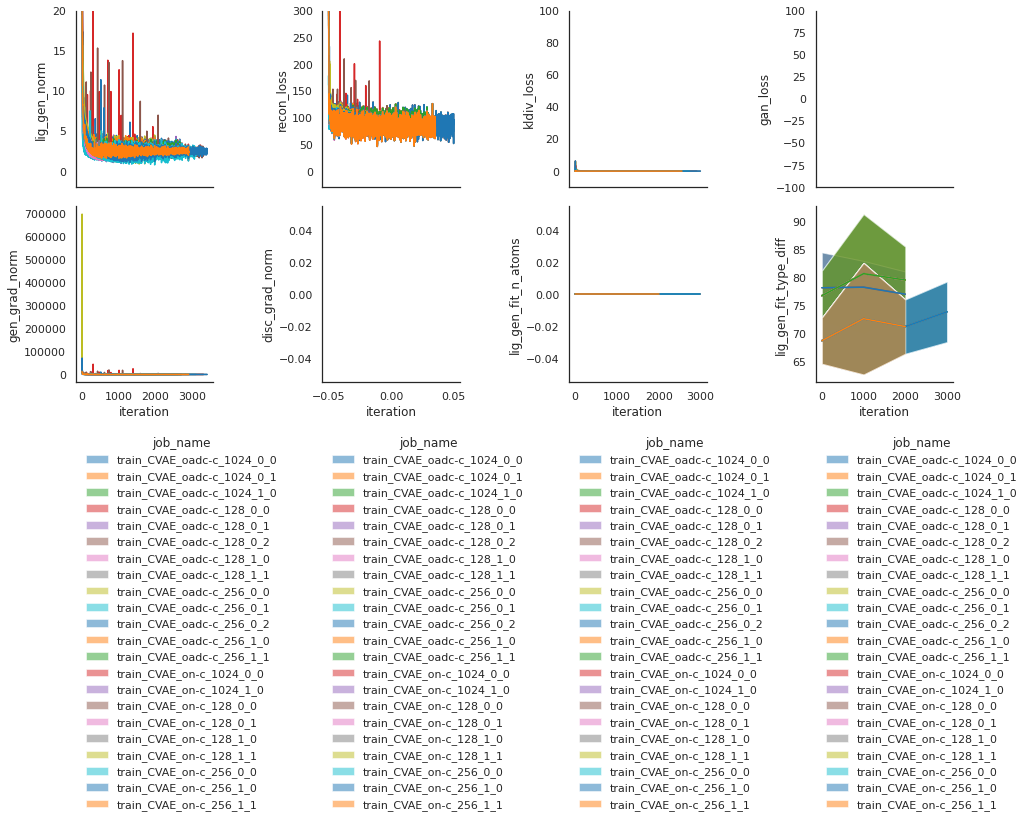

In [420]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set_context('notebook')

def safe_sem(x):
    return scipy.stats.sem(x) if len(x) > 1 else np.nan

def my_plot(data, x, y, hue, ax, **kwargs):
    for h, hue_data in data.groupby(hue):
        hue_data = hue_data[~hue_data[y].isna()]
        try:
            mean = hue_data.groupby(x)[y].agg(np.nanmean)
            sem = hue_data.groupby(x)[y].agg(safe_sem)
            ax.fill_between(mean.index, mean - 2*sem, mean + 2*sem, alpha=0.5, label=h)
            ax.plot(mean.index, mean, label=h) #, marker='x')
        except Exception as e:
            print(e, hue_data[y].dtype, y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

plot_df = train_metrics.reset_index()

fig = param_search.plot(
    plot_df[
        (plot_df['model_phase'] != 'disc') &
        (plot_df['model_type'] == 'CVAE') &
        (plot_df['radius_fn'] == 'c')
    ],
    x='iteration',
    y=[
        'lig_gen_norm',
        'recon_loss',
        'kldiv_loss',
        'gan_loss',
        'gen_grad_norm',
        'disc_grad_norm',
        'lig_gen_fit_n_atoms',
        'lig_gen_fit_type_diff'
    ],
    hue='job_name',
    n_cols=4,
    width=3.5,
    height=6,
    plot_func=my_plot,
    ylim=dict(
        lig_gen_norm=[-2, 20],
        recon_loss=[-30, 300],
        kldiv_loss=[-10, 100],
        gan_loss=[-100, 100],
    )
)

In [374]:
train_metrics.columns

Index(['iteration', 'data_phase', 'batch', 'loss', 'recon_loss', 'kldiv_loss',
       'lig_norm', 'lig_variance', 'lig_gen_norm', 'lig_gen_variance',
       'lig_gen_L2_loss', 'lig_gen_fit_n_atoms', 'lig_gen_fit_radius',
       'lig_n_atoms', 'lig_radius', 'lig_gen_fit_type_diff',
       'lig_gen_fit_exact_types', 'lig_gen_fit_atom_rmsd', 'forward_data_time',
       'forward_gen_time', 'forward_fit_time', 'forward_metrics_time',
       'forward_time', 'forward_gpu', 'memory', 'gen_grad_norm',
       'backward_time', 'backward_grad_time', 'backward_norm_time',
       'backward_update_time', 'backward_gpu', 'random_seed', 'data_root',
       'train_file', 'test_file', 'model_type', 'typer_fns', 'radius_fn',
       'n_latent', 'gen_spectral_norm', 'optim_type', 'gen_lr', 'disc_lr',
       'gen_grad_clip', 'disc_grad_clip', 'n_gen_train_iters',
       'n_disc_train_iters', 'job_name', 'disc_iter', 'model_phase',
       'grid_phase', 'gan_loss', 'pred_mean', 'pred_variance',
       'forward